In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Rotated and scaled')

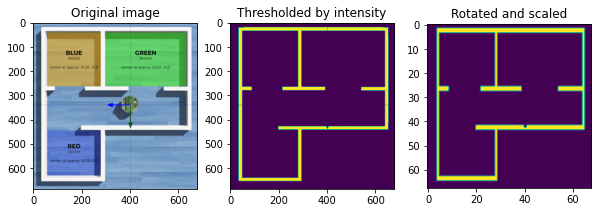

In [3]:
%matplotlib inline

fix, ax = plt.subplots(1, 3, figsize=(10, 5))

im = cv2.imread('data/map_webots.png')
ax[0].imshow(im)
ax[0].set_title('Original image')

gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
gray = (gray >= 246).astype(np.uint8)
ax[1].imshow(gray)
ax[1].set_title('Thresholded by intensity')

resize_factor = 9.95
map_ground = cv2.resize(gray, (int(gray.shape[0] / resize_factor), int(gray.shape[1] / resize_factor)))
map_ground[map_ground < 0.5] = 0
map_ground[map_ground >= 0.5] = 1
map_ground = map_ground.astype(np.float32)
ax[2].imshow(map_ground)
ax[2].set_title('Rotated and scaled')

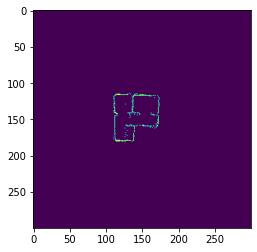

In [4]:
%matplotlib inline


def get_constructed_map(filename):
    map_phy = cv2.cvtColor(cv2.imread(f'data/{filename}.pgm'), cv2.COLOR_BGR2GRAY)
    map_phy = cv2.rotate(map_phy, cv2.ROTATE_180)
    map_phy = (map_phy < 0.5)
    map_phy[map_phy < 0.5] = 0
    map_phy[map_phy >= 0.5] = 1
    return map_phy.astype(np.float32)


map_phy = get_constructed_map('map_phy_2')
plt.imshow(map_phy)

In [5]:
def get_iou(im1, im2):
    intersection = cv2.bitwise_and(im1, im2)
    union = cv2.bitwise_or(im1, im2)
    return np.sum(intersection) / np.sum(union)

def find_min_diff_image(image, sub_image):
    w, h = sub_image.shape
    max_iou = None
    min_x, min_y = 0, 0
    for i in range(0, image.shape[0] - w):
        for j in range(0, image.shape[1] - h):
            map_diff = image.copy()
            iou = get_iou(map_diff[i:i+w, j:j+h], sub_image)
            if max_iou is None or iou > max_iou:
                max_iou = iou
                min_x = i
                min_y = j
                
    return max_iou, min_x, min_y

for i in range(1, 4, 1):
    map_phy = get_constructed_map(f'map_phy_{i}')
    iou, x, y = find_min_diff_image(map_phy, map_ground)
    print(iou, x, y)
    
    
map_sim = get_constructed_map(f'map_8ts')
iou, x, y = find_min_diff_image(map_sim, map_ground)
print(iou, x, y)

0.2792208 116 108
0.2596006 115 108
0.29588607 115 108
0.2993197 115 110


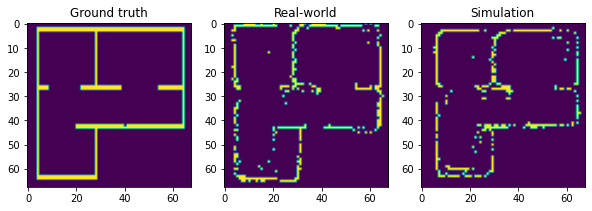

In [6]:
SUBIMAGE_XY = (115, 108)

def get_matching_subimage(image, subimage):
    w, h = subimage.shape
    return image[SUBIMAGE_XY[0]:SUBIMAGE_XY[0]+w, SUBIMAGE_XY[1]:SUBIMAGE_XY[1]+h]

map_phy = get_constructed_map(f'map_phy_1')
map_sim = get_constructed_map(f'map_8ts')

fix, ax = plt.subplots(1, 3, figsize=(10, 5))

ax[0].imshow(map_ground)
ax[0].set_title('Ground truth')
ax[1].imshow(get_matching_subimage(map_phy, map_ground))
ax[1].set_title('Real-world')
ax[2].imshow(get_matching_subimage(map_sim, map_ground))
ax[2].set_title('Simulation')

plt.savefig('map_comparison.pdf', bbox_inches='tight', pad_inches=0.01)